###Installing Dependencies

In [ ]:
!pip install -q numpy==1.26.4
!pip install -q librosa==0.10.2.post1
!pip install -q soundfile==0.12.1
!pip install -q scipy
!pip install -q tqdm==4.66.5
!pip install -q noisereduce
!pip install -q pandas==2.2.2
!pip install -q webrtcvad==2.0.10
!pip install -q matplotlib==3.7.1
!pip install -q seaborn==0.13.1
!pip install -q torchaudio==2.4.1
!pip install -q python_speech_features

###Importing Dependencies

In [10]:
import os
import numpy as np
import librosa
import soundfile as sf
from scipy import signal
from tqdm import tqdm
import noisereduce as nr
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import webrtcvad
import struct
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
from python_speech_features import mfcc, logfbank
from re import I
import seaborn as sns
import warnings
import os
from tqdm import tqdm
from scipy.io import wavfile
import warnings
import random
import torchaudio
from IPython.display import Audio, display

warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore')

###Loading Training Data for Visualizing Original Audio Data



In [11]:
df = pd.read_csv('/content/Train (1).csv')[:300]
df.set_index('audio_filepath', inplace=True)
audio_path = "/content/drive/MyDrive/TechCabal Ewe Audio Files/"

for f in df.index:
    rate, signal = wavfile.read(audio_path + f)
    df.at[f, 'length'] = signal.shape[0]/rate
df.head()

,id,duration,class,length
audio_filepath,,,,
id_6nazjwygdl.wav,id_6nazjwygdl,1.984,left,1.984
id_jpwl97yilf.wav,id_jpwl97yilf,2.027,down,2.027
id_9d131fb32p.wav,id_9d131fb32p,2.274,go,2.274
id_kat2oty4s0.wav,id_kat2oty4s0,2.176,down,2.176
id_g3hvae3jbe.wav,id_g3hvae3jbe,1.634,down,1.634


##Helper Function
plot_signal(signal) – Plots time-domain signals in a grid of subplots.
plot_fft(fft) – Plots the frequency domain (FFT) of signals.
plot_fbank(fbank) – Visualizes filter bank coefficients as heatmaps.
plot_mfccs(mfccs) – Displays MFCCs as heatmaps, used in audio analysis.
cal_fft(signal, rate) – Computes the FFT to convert a signal to its frequency spectrum.
envelope(y, rate, threshold) – Creates a mask by applying a threshold to the smoothed signal.

In [12]:
def plot_signal(signal):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle("Time Series", size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            if i < len(signal):
                ax[x,y].set_title(list(signal.keys())[i])
                ax[x,y].plot(list(signal.values())[i])
                ax[x,y].get_xaxis().set_visible(False)
                ax[x,y].get_yaxis().set_visible(False)
                i += 1
            else:
                ax[x,y].axis('off')

def plot_fft(fft):
    n = len(fft)
    fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(10, 3 * n))
    for i in range(n):
        data = list(fft.values())[i]
        y, freq = data[0], data[1]
        if n > 1:
            curr_ax = ax[i]
        else:
            curr_ax = ax
        curr_ax.set_title(list(fft.keys())[i])
        curr_ax.plot(freq, y)
        curr_ax.get_xaxis().set_visible(False)
    plt.tight_layout()

def plot_fbank(fbank):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle("Filter Bank Coefficients", size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            if i < len(fbank):
                ax[x,y].set_title(list(fbank.keys())[i])
                ax[x,y].imshow(list(fbank.values())[i], cmap='hot', interpolation='nearest')
                ax[x,y].get_xaxis().set_visible(False)
                ax[x,y].get_yaxis().set_visible(False)
                i += 1
            else:
                ax[x,y].axis('off')

def plot_mfccs(mfccs):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle("Mel Frequency Cepstrum Coefficients", size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            if i < len(mfccs):
                ax[x,y].set_title(list(mfccs.keys())[i])
                ax[x,y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest')
                ax[x,y].get_xaxis().set_visible(False)
                ax[x,y].get_yaxis().set_visible(False)
                i += 1
            else:
                ax[x,y].axis('off')

def cal_fft(signal, rate):
    n = len(signal)
    freq = np.fft.rfftfreq(n, d=1/rate)
    y = abs(np.fft.rfft(signal)/n)
    return y, freq

def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

###Plot Distribution For 300 Sample Data

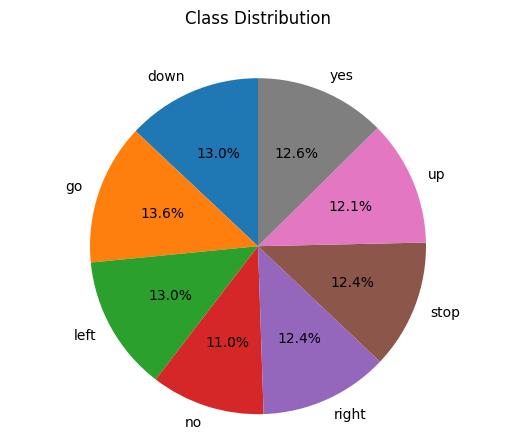

In [13]:
classes = list(np.unique(df['class']))
class_dist = df.groupby(['class'])["length"].mean()

fig, ax = plt.subplots()
ax.set_title("Class Distribution", y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()

df.reset_index(inplace=True)

###Visualizing Original Audio Data

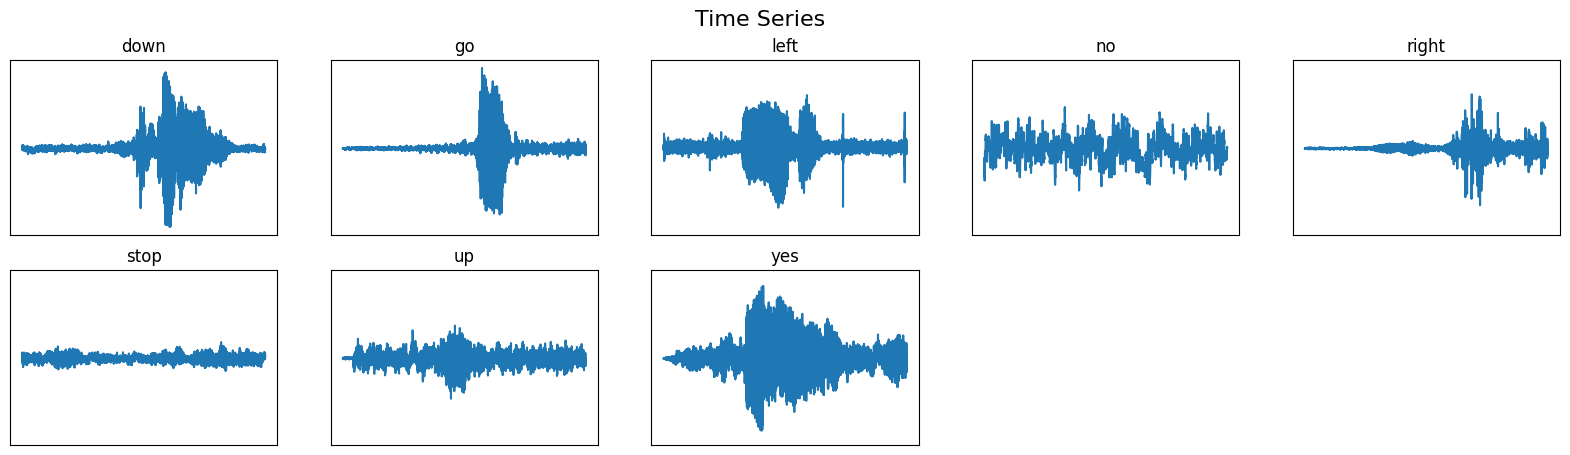

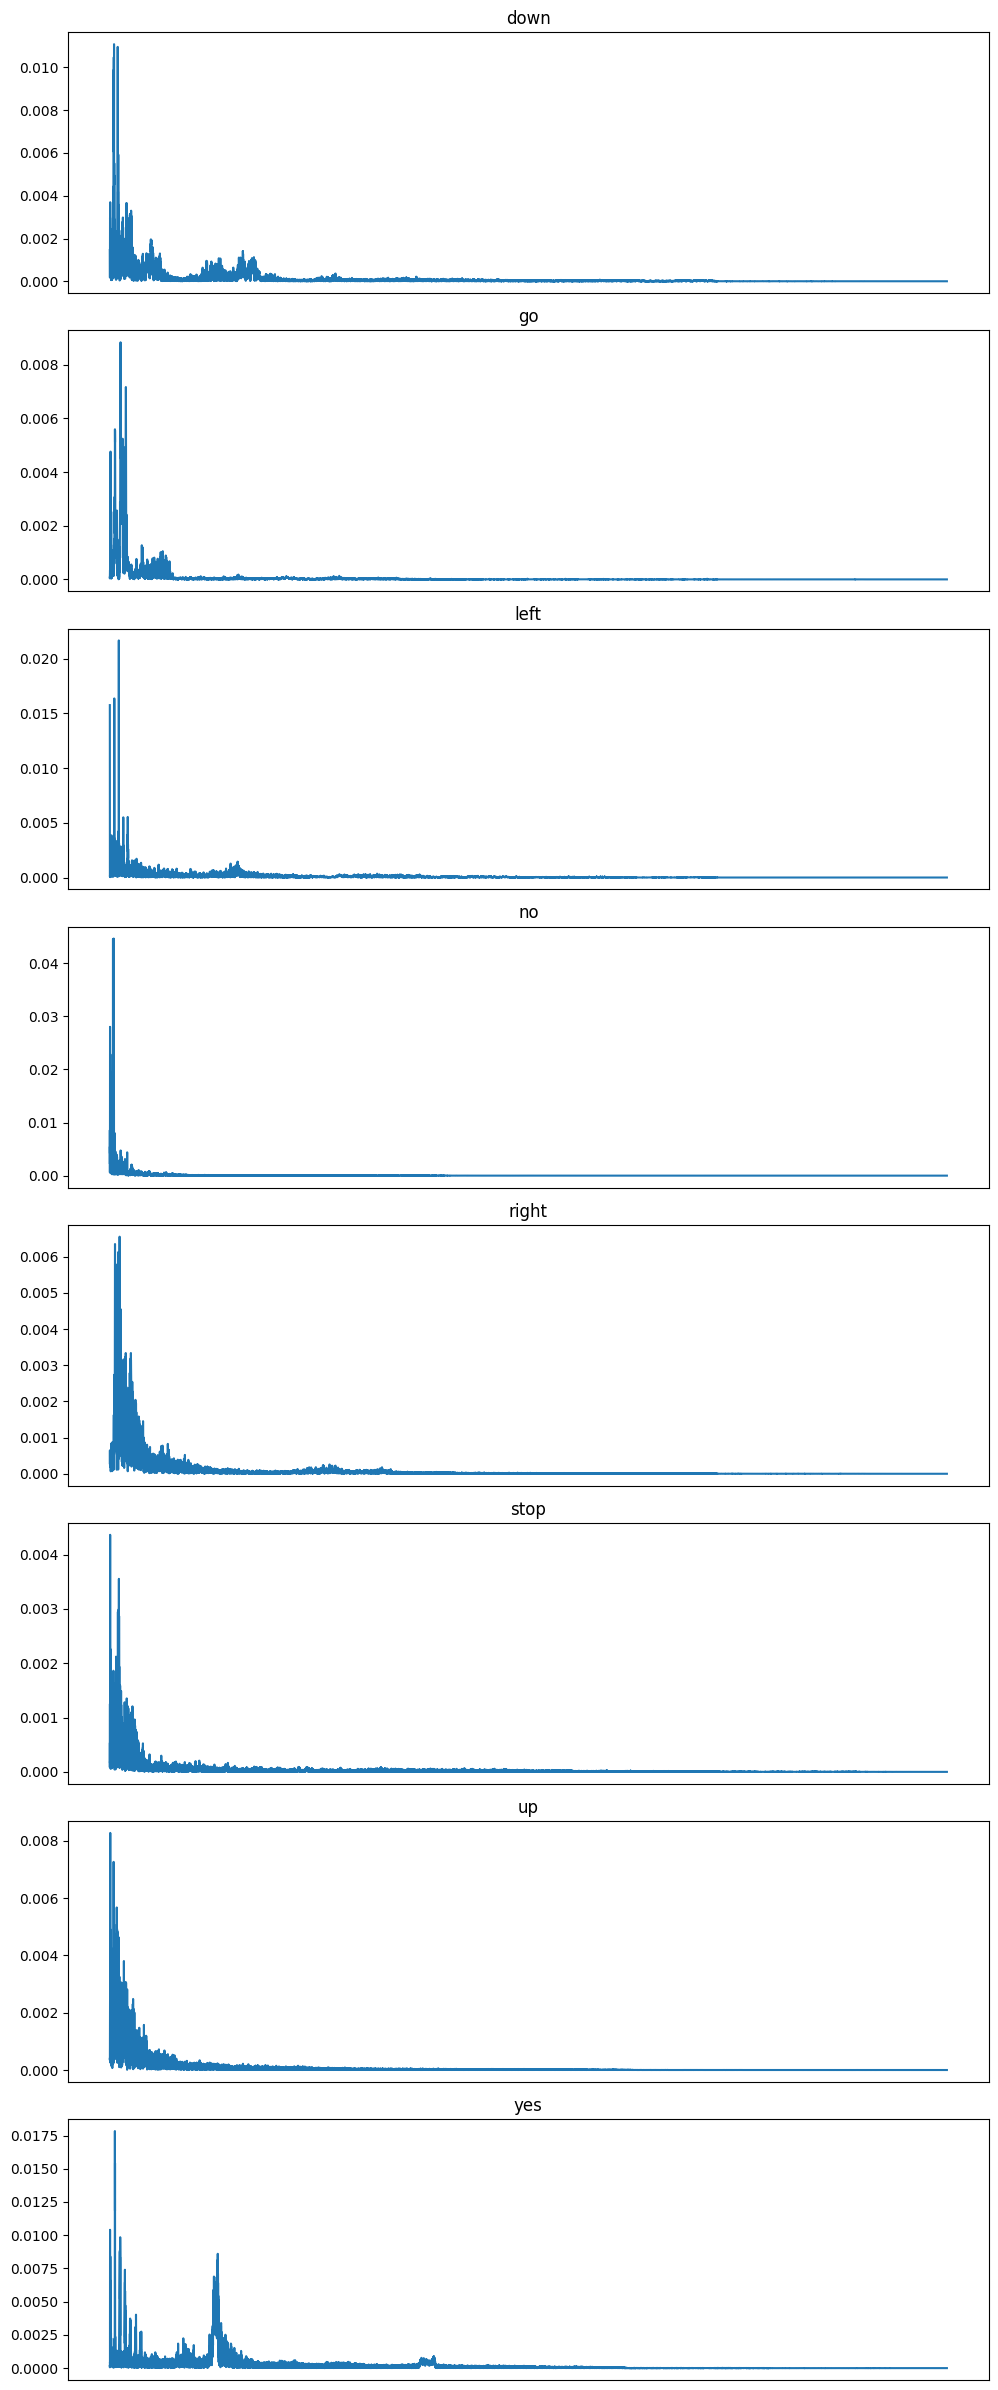

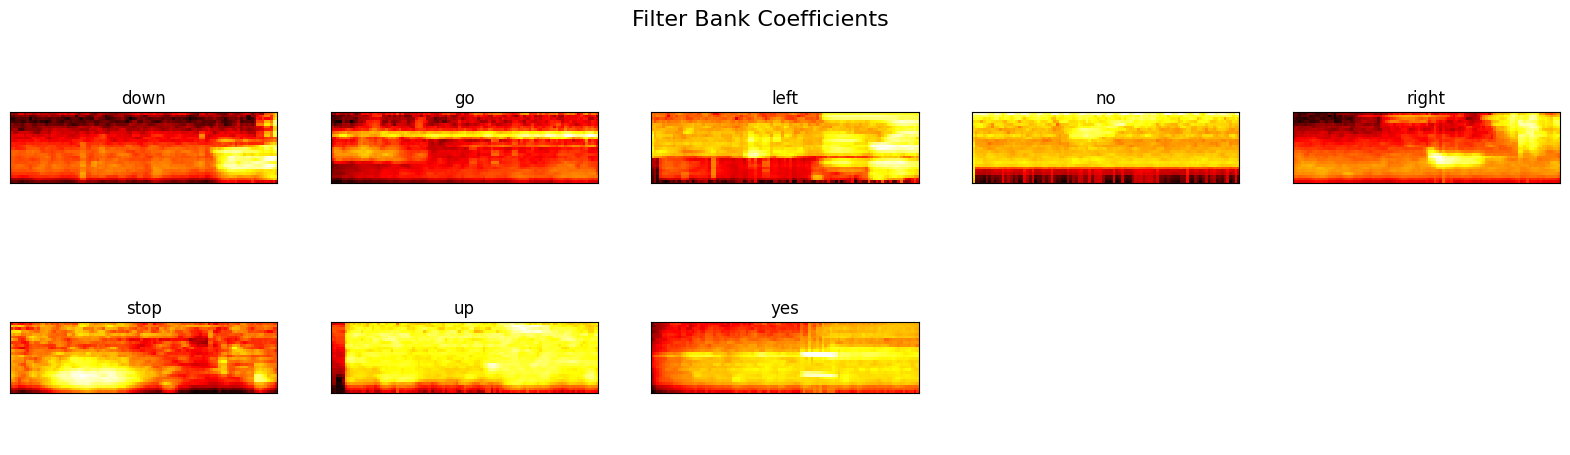

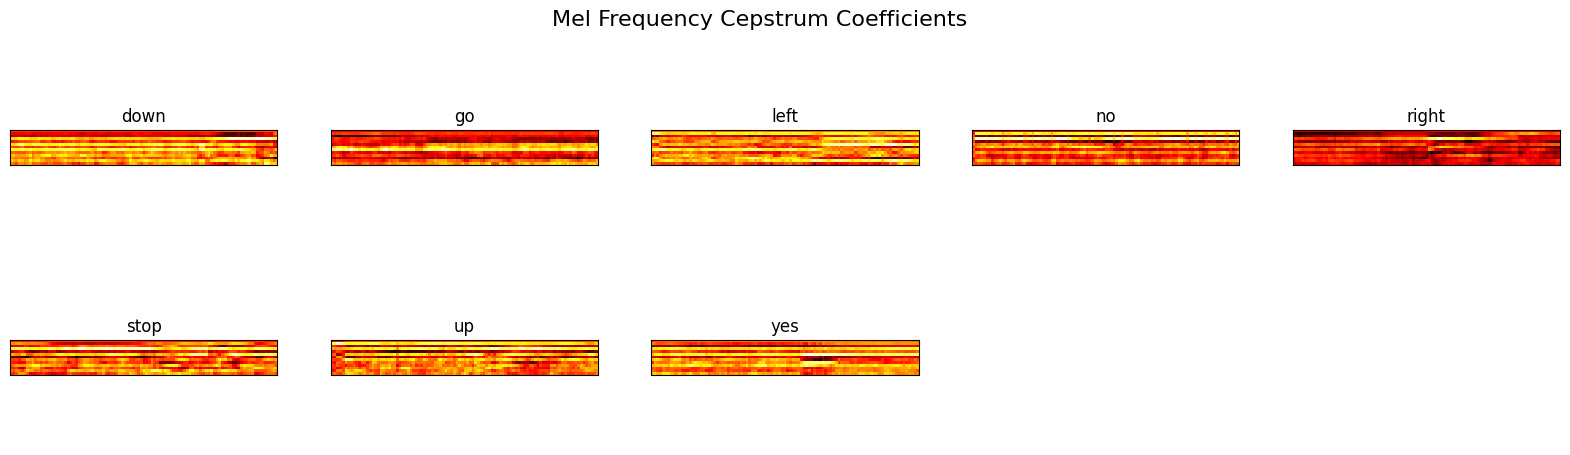

In [14]:
signal_dict = {}
fft_dict = {}
fbank_dict = {}
mfccs_dict = {}

for c in classes:
    wave_file = df[df['class'] == c].iloc[0, 0]
    signal, sr = librosa.load(audio_path + wave_file, sr=44100)
    signal_dict[c] = signal
    fft_dict[c] = cal_fft(signal_dict[c], sr)
    bank = logfbank(signal[:sr], sr, nfilt=26, nfft=1103).T
    fbank_dict[c] = bank
    mel = mfcc(signal[:sr], sr, numcep=13, nfilt=26, nfft=1103).T
    mfccs_dict[c] = mel

plot_signal(signal_dict)
plt.show()

plot_fft(fft_dict)
plt.show()

plot_fbank(fbank_dict)
plt.show()

plot_mfccs(mfccs_dict)
plt.show()

###Visualizing Audio with Mel Spectrograms and Silence Removal




In [15]:
def load_audio(file_path, sr=22050):
    """Load audio file and resample if necessary."""
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

def plot_mel_spectrogram(waveform, sample_rate):
    """Plot the Mel spectrogram of an audio waveform."""
    # Convert to Mel spectrogram
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)

    # If the waveform has multiple channels, take the mean to convert it to mono
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0).unsqueeze(0)

    mel_spectrogram = transform(waveform)
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram_db.squeeze().numpy(), cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency (Mel)')
    plt.show()

def play_and_plot(audio_filepath):
    """Load, play, and plot Mel spectrogram of an audio file."""
    # Load audio file
    waveform, sample_rate = torchaudio.load(audio_filepath)

    # Play audio
    print("Playing audio...")
    display(Audio(waveform.mean(dim=0).numpy(), rate=sample_rate))

    # Plot Mel spectrogram
    plot_mel_spectrogram(waveform, sample_rate)


def visualize_silence_removal(audio, sr, threshold_db=-40, min_silence_duration=0.1):
    """Visualize the effect of silence removal on the waveform."""
    # Detect non-silent intervals
    non_silent_intervals = librosa.effects.split(audio, top_db=-threshold_db, frame_length=int(sr * min_silence_duration))

    # Plot original audio waveform
    plt.figure(figsize=(14, 6))
    librosa.display.waveshow(audio, sr=sr, alpha=0.6, label='Original Audio')

    # Plot silence intervals on the waveform
    for interval in non_silent_intervals:
        plt.axvspan(interval[0] / sr, interval[1] / sr, color='red', alpha=0.3, label='Non-Silent Regions')

    plt.title(f'Silence Removal Visualization (Threshold: {threshold_db} dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def tune_silence_threshold(file_path, threshold_db_list=[-20, -30, -40, -50], min_silence_duration=0.1):
    """Tune the silence threshold by visualizing with different dB levels."""
    audio, sr = load_audio(file_path)

    for threshold_db in threshold_db_list:
        print(f'Visualizing for silence threshold: {threshold_db} dB')
        visualize_silence_removal(audio, sr, threshold_db=threshold_db, min_silence_duration=min_silence_duration)



Visualizing for silence threshold: -20 dB


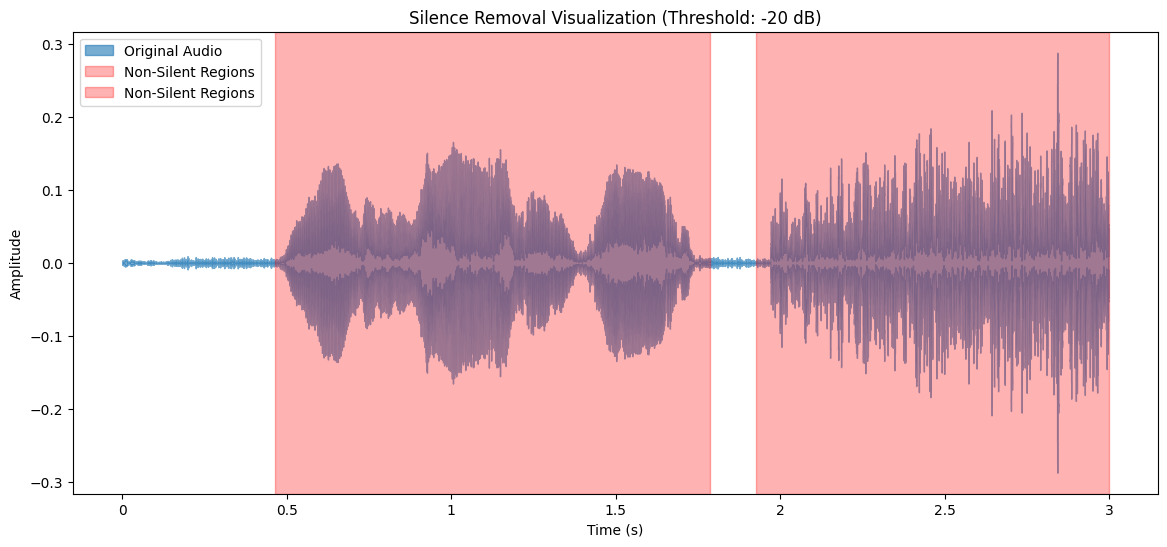

Visualizing for silence threshold: -30 dB


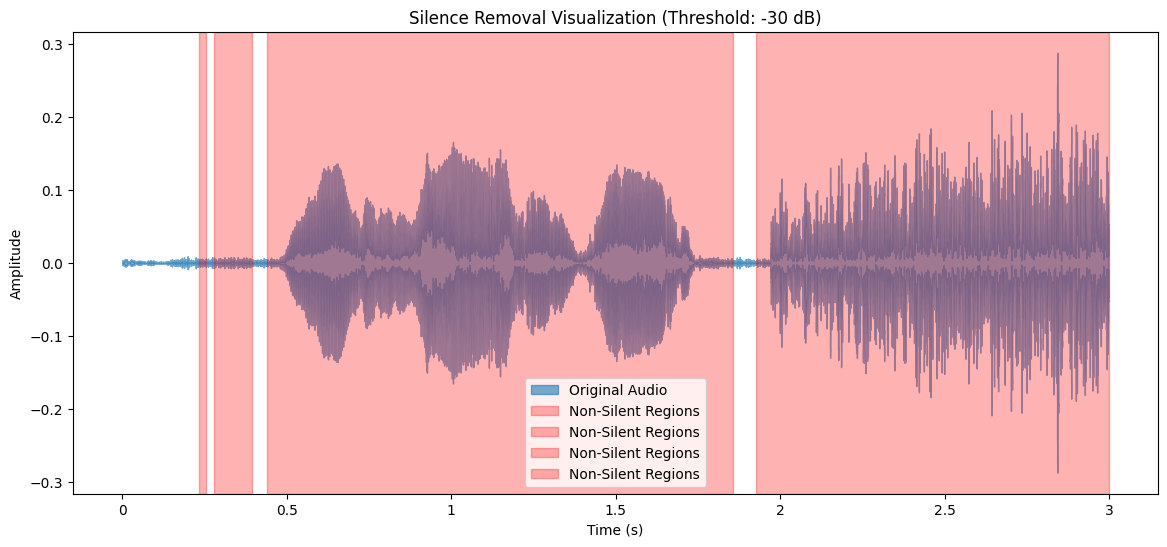

Visualizing for silence threshold: -40 dB


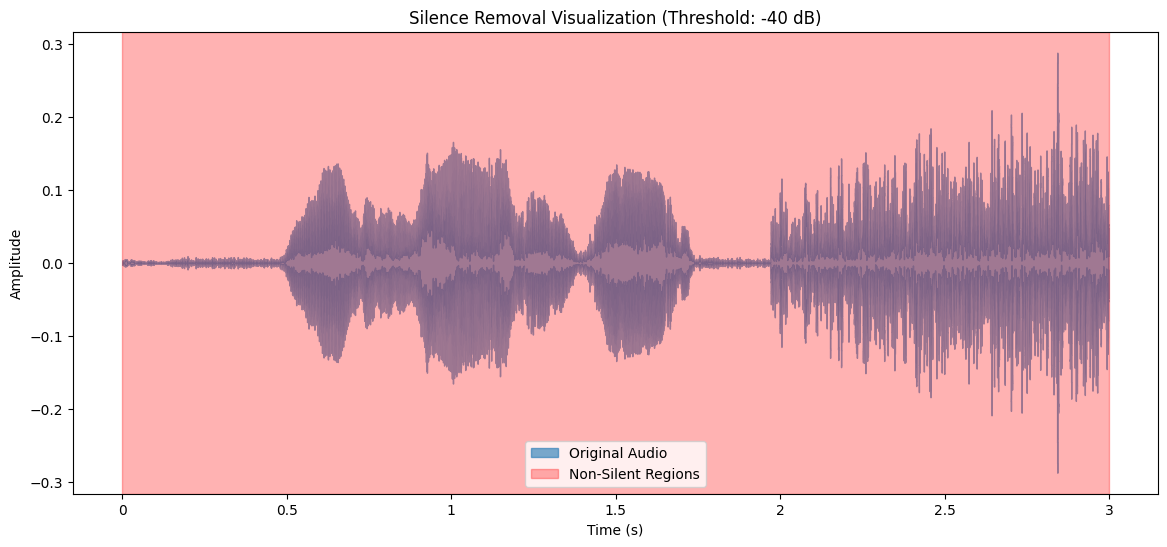

Visualizing for silence threshold: -50 dB


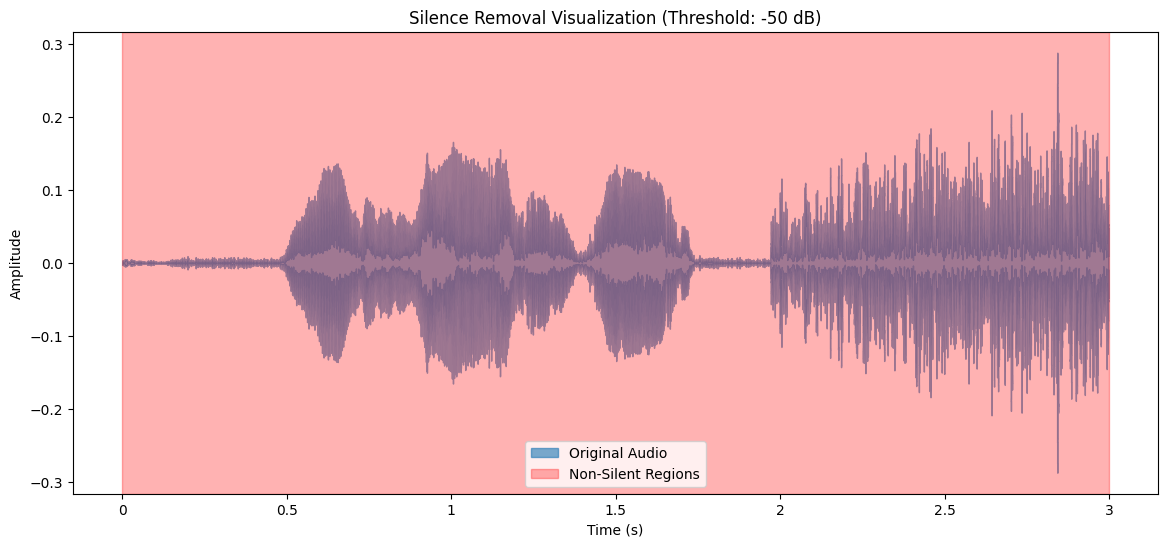

Playing audio...


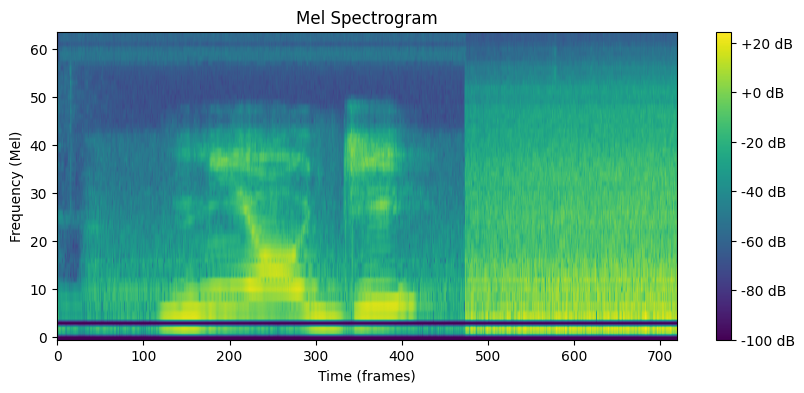

In [16]:
test_audio = '/content/drive/MyDrive/TechCabal Ewe Audio Files/id_0102r11epj.wav'
tune_silence_threshold(test_audio, threshold_db_list=[-20, -30, -40, -50])
play_and_plot(test_audio)


##CLEANING AUDIO DATA

In [ ]:
def load_audio(file_path, sr=22050):
    """Load audio file and resample if necessary."""
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

def remove_silence(audio, sr, threshold_db=-30, min_silence_duration=0.1):
    """Remove silent parts from the audio."""
    non_silent_intervals = librosa.effects.split(audio, top_db=-threshold_db, frame_length=int(sr * min_silence_duration))
    return np.concatenate([audio[start:end] for start, end in non_silent_intervals])

def apply_bandpass_filter(audio, sr, lowcut=300, highcut=3400):
    """Apply a bandpass filter to focus on speech frequencies."""
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(6, [low, high], btype='band')
    return signal.lfilter(b, a, audio)

def reduce_noise(audio, sr):
    """Apply noise reduction."""
    return nr.reduce_noise(y=audio, sr=sr)

def normalize_audio(audio):
    """Normalize audio to a consistent volume level."""
    return librosa.util.normalize(audio)

def apply_spectral_subtraction(audio, sr):
    """Apply spectral subtraction for noise reduction."""
    noise_sample = audio[:int(sr * 0.5)]
    noise_spectrum = np.mean(np.abs(librosa.stft(noise_sample))**2, axis=1)
    audio_stft = librosa.stft(audio)
    audio_power = np.abs(audio_stft)**2
    audio_power_reduced = np.maximum(audio_power - noise_spectrum[:, np.newaxis], 0)
    audio_stft_reduced = audio_stft * np.sqrt(audio_power_reduced / np.maximum(audio_power, 1e-10))
    return librosa.istft(audio_stft_reduced)

def apply_audio_cleaning(file_path, output_path):
    """Apply the full audio cleaning pipeline."""

    audio, sr = load_audio(file_path)
    audio = remove_silence(audio, sr)
    audio = apply_bandpass_filter(audio, sr)
    audio = reduce_noise(audio, sr)
    audio = apply_spectral_subtraction(audio, sr)
    audio = normalize_audio(audio)
    sf.write(output_path, audio, sr)

def process_dataset(input_folder, output_folder):
    """Process entire dataset."""
    os.makedirs(output_folder, exist_ok=True)

    audio_files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]

    for filename in tqdm(audio_files, desc="Processing audio files"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        apply_audio_cleaning(input_path, output_path)

In [ ]:
process_dataset('/content/drive/MyDrive/TechCabal Ewe Audio Files', '/content/drive/MyDrive/Cleaned_TechCabal_01')

Processing audio files: 100%|██████████| 8280/8280 [1:02:55<00:00,  2.19it/s]


###Checking the Length of the Original and Cleaned Data

In [ ]:
len(os.listdir("/content/drive/MyDrive/TechCabal Ewe Audio Files")) , len(os.listdir("/content/drive/MyDrive/Cleaned_TechCabal_01"))

(8280, 8280)

###Loading Training Data for Visualizing Cleaned Audio Data

In [18]:
df_new = pd.read_csv('/content/Train (1).csv')[:300]
df_new.set_index('audio_filepath', inplace=True)
audio_path = "/content/drive/MyDrive/Cleaned_TechCabal_01/"

for f in df_new.index:
    rate, signal = wavfile.read(audio_path + f)
    df_new.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df_new['class']))
class_dist = df.groupby(['class'])["length"].mean()

In [19]:
df_new["length"].max()

2.995374149659864

In [20]:
df_new.isna().sum()

,0
id,0
duration,0
class,0
length,0


###visualizing Cleaned Audio Data

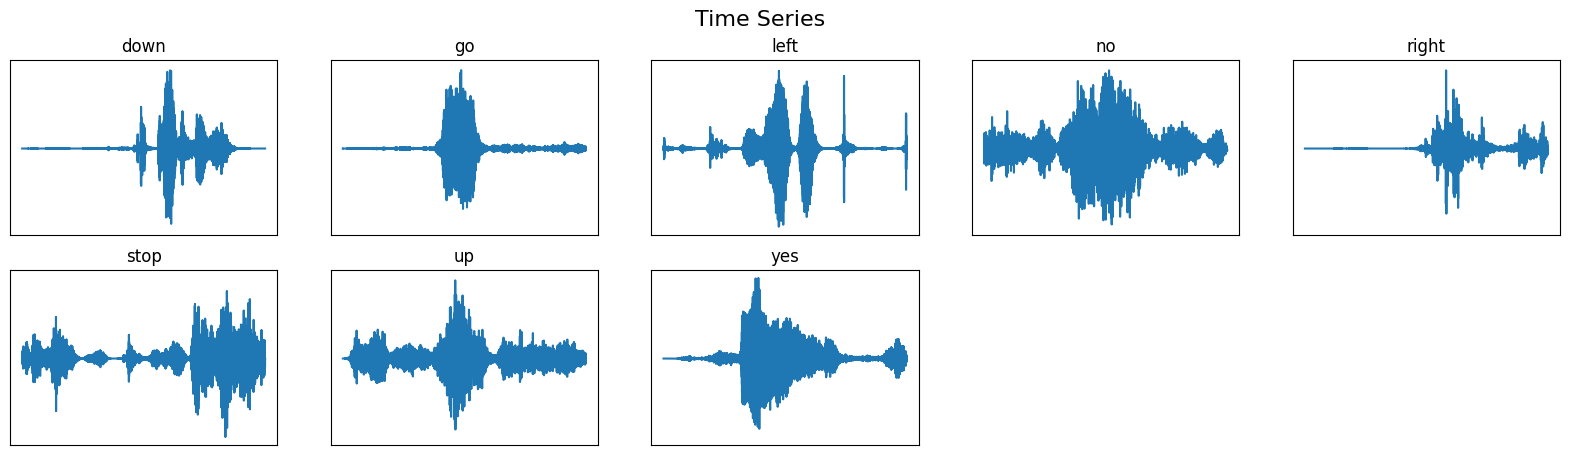

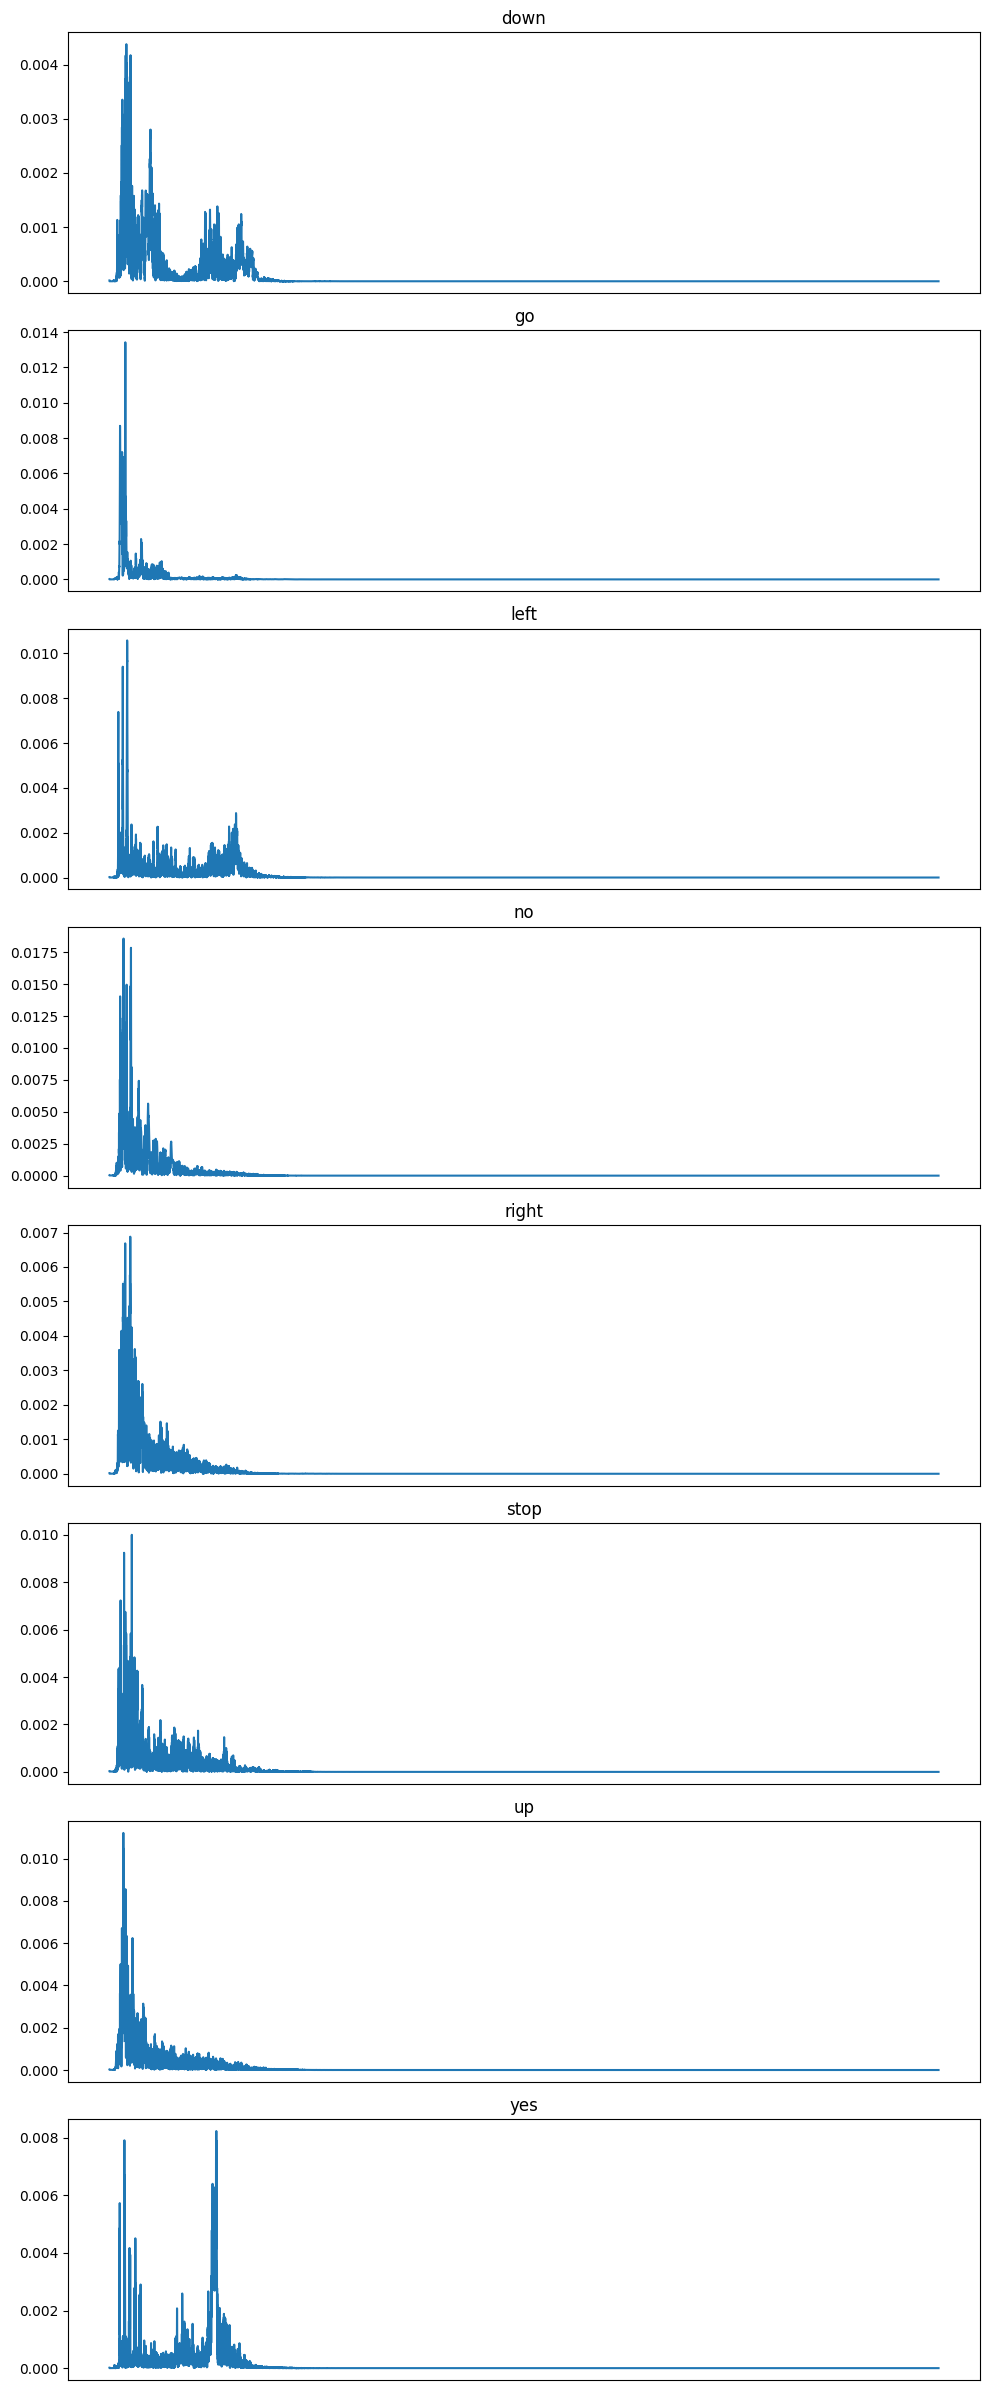

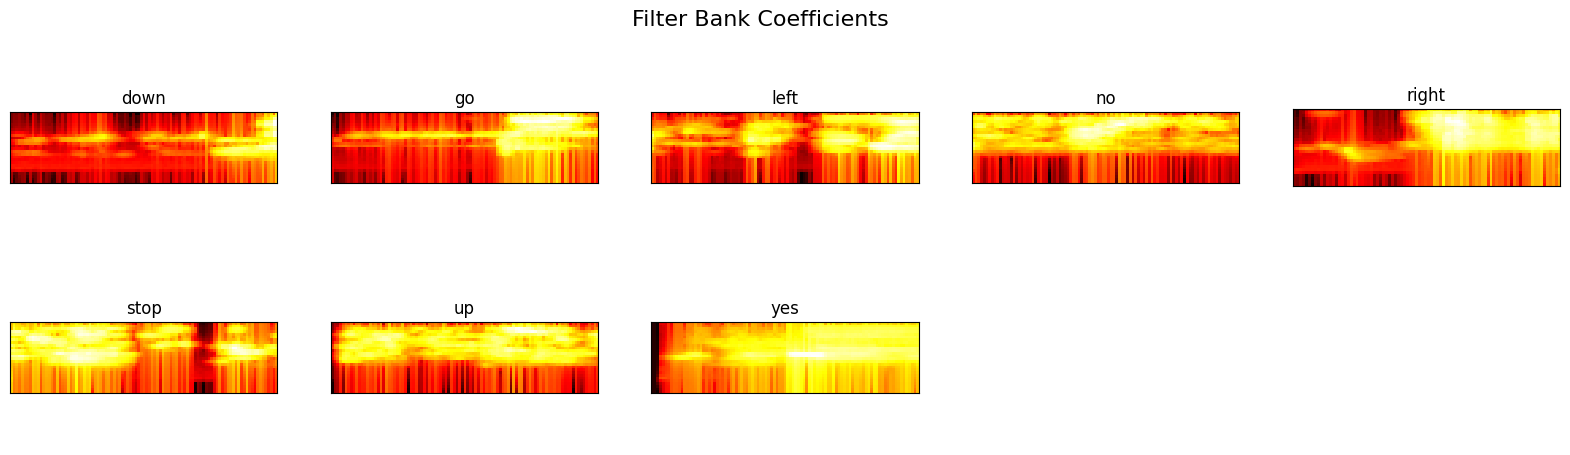

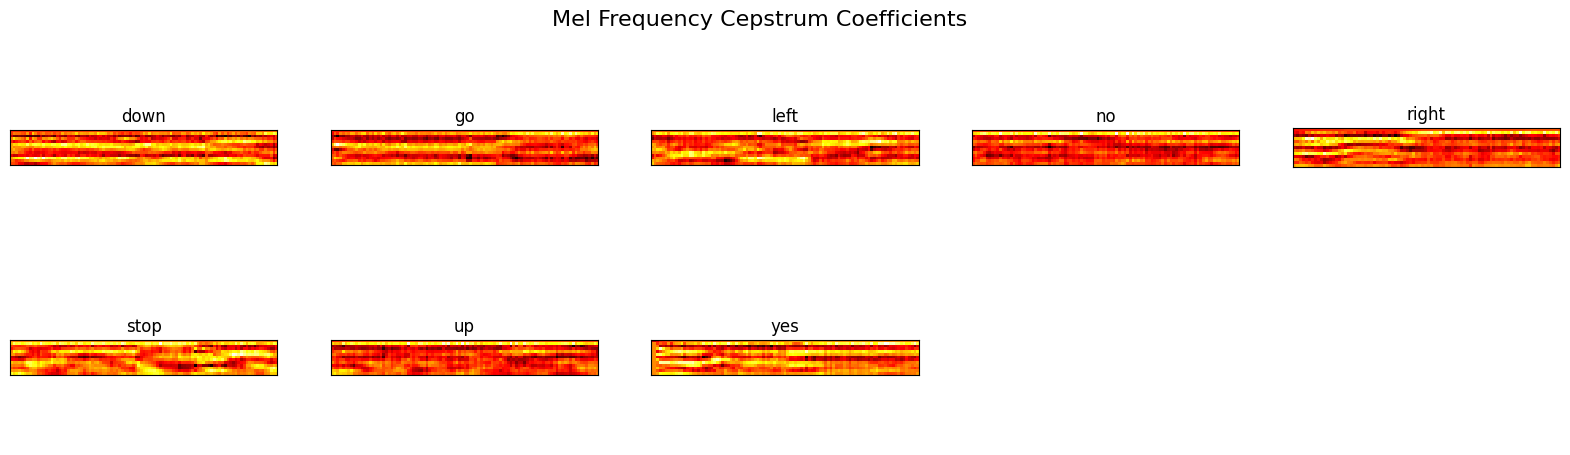

In [21]:
signal_dict = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wave_file = df_new[df_new['class'] == c].iloc[0, 0]
    signal, sr = librosa.load(audio_path + wave_file+".wav", sr=44100)
    signal_dict[c] = signal
    fft[c] = cal_fft(signal_dict[c], sr)
    bank = logfbank(signal[:sr], sr, nfilt=26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:sr], sr, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

plot_signal(signal_dict)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()
